## <center>Prueba Tecnica</center>
#### <center>Autor:</center>
##### <center>Sebastian Carvalho Salazar:</center>

# Imputación de Datos

#  Librerias

In [162]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import missingno
from scipy.stats import iqr

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [163]:
df = pd.read_excel('..//in//Datos_EDA.xlsx', index_col=0)

## Analisis de datos atipicos

Se logra identificar en la gráfica a continuación que el conjunto de datos se encuentra desbalanceado ya que contiene muchos más casos de Éxito que de Fracaso. 

<AxesSubplot:>

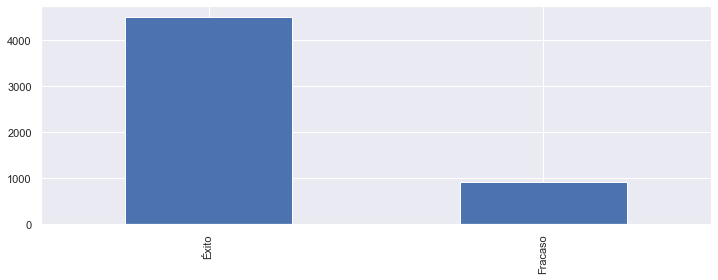

In [164]:
plt.figure(figsize=(12,4))
df['estado_final'].value_counts().plot(kind='bar')

los boxplots son una herramienta visual útil para identificar observaciones que se alejan significativamente del resto de los datos. Estas observaciones pueden ser errores de medición, valores atípicos reales o simplemente datos extremos que pueden tener un impacto desproporcionado en los resultados del análisis.

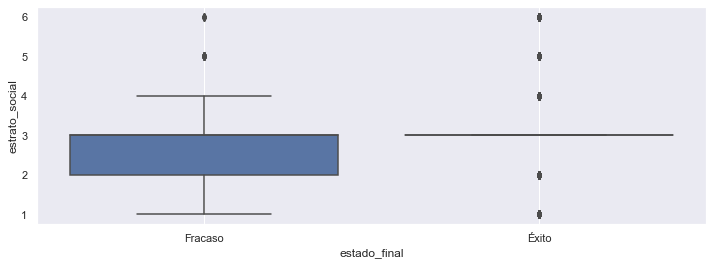

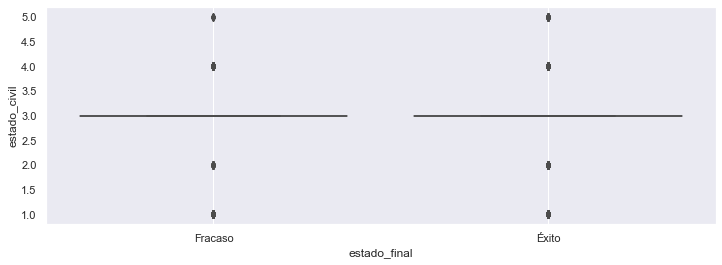

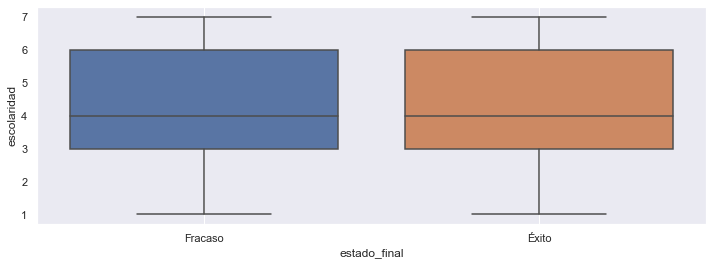

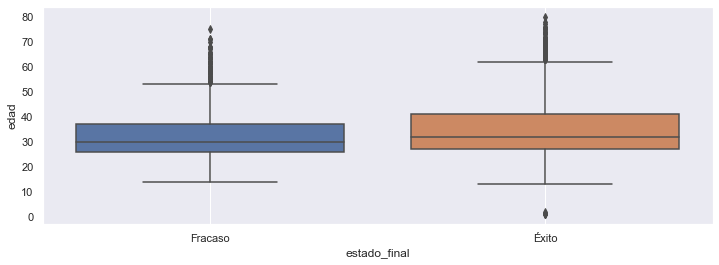

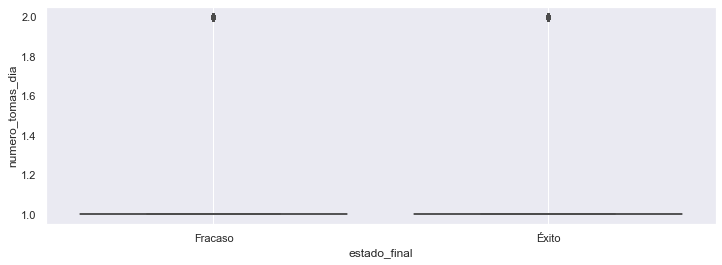

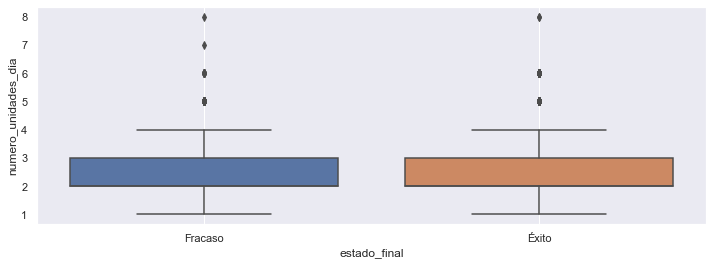

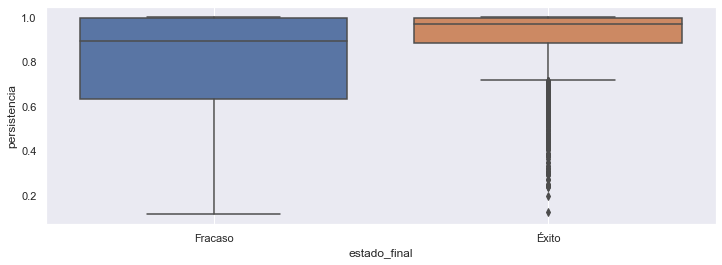

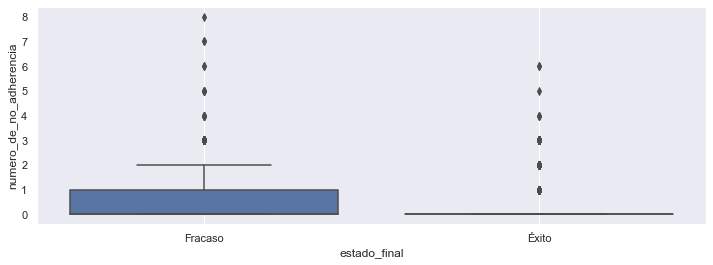

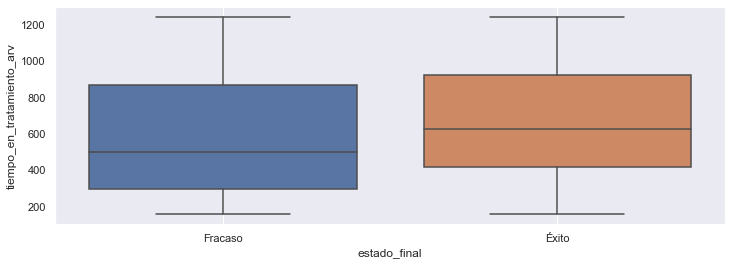

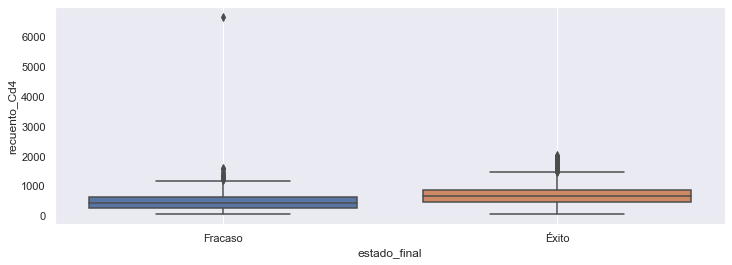

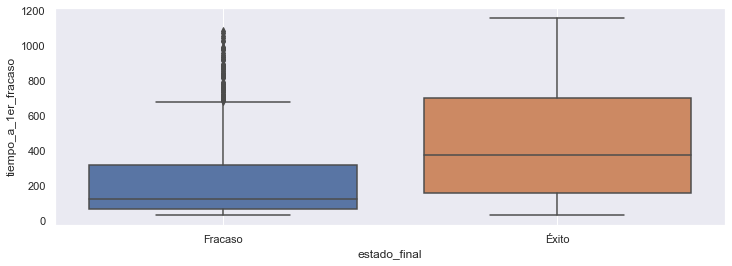

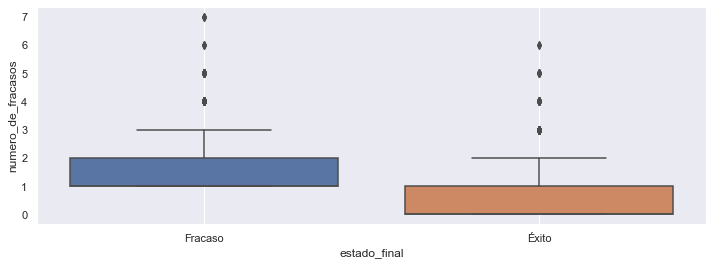

In [165]:
headers = df.select_dtypes(include=['int', 'float']).columns
sns.set(rc={'figure.figsize':(12,4)})
for i in range(len(headers)-1):
    sns.boxplot(x="estado_final",y=headers[i], data=df)
    plt.grid()
    plt.show()

# Imputación de Valores Faltantes

### Copia de los datos

In [166]:
df_2 = df.copy(deep=True)
df_2 = df_2.drop(['estado_final'], axis=1)

### Columnas con datos faltantes

In [167]:
df_2.isna().sum().sort_values(ascending=False)[0:21]

LDL_categorico           2342
preferencia              1194
Rango_TG                 1128
TG_categorico            1128
HDL_categorico            896
CT_categorico             768
Rango_CT                  768
recuento_Cd4              370
acompanante               263
ocupacion                 122
grupos_farmacologicos      71
regimen                    59
estado_civil               18
edad                       18
zona_cox                   16
genero                     16
estrato_social             16
escolaridad                16
esquema_arv                13
numero_tomas_dia           13
numero_unidades_dia        13
dtype: int64

### Imputación de datos usando Bootstraping

Es necesario imputar datos faltantes debido a que la presencia de estos puede reducir la precisión y representatividad de los análisis de datos. Si no se tratan los valores faltantes, los datos disponibles pueden sesgar los resultados del análisis y dificultar la detección de patrones y relaciones importantes. Además, la eliminación completa de las observaciones con valores faltantes puede reducir significativamente el tamaño y la representatividad de la muestra, lo que a su vez puede disminuir la precisión de los resultados, por lo que en esta ocasión  se a optado por Bootstraping para el llenado de los datis faltantes.

In [168]:
def bootstrap_impute(column):
    """Función para imputar valores faltantes por bootstrapping"""
    # Creamos una copia de la columna
    imputed_column = column.copy()
    # Creamos una máscara booleana para los valores faltantes
    is_missing = imputed_column.isna()
    # Generamos una muestra aleatoria con reemplazo de los valores no faltantes
    sample = imputed_column[~is_missing].sample(n=is_missing.sum(), replace=True)
    # Reemplazamos los valores faltantes con los valores de la muestra aleatoria
    imputed_column[is_missing] = sample.values
    return imputed_column

In [169]:
# Imputamos los valores faltantes usando bootstrapping
df_2_imputed = df_2.apply(bootstrap_impute)

In [170]:
df_2_imputed.isna().sum().sum()

0

### Encoding

Es útil usar One Hot Encoding en variables categóricas porque permite convertir estas variables en una forma numérica que es más fácil de manejar y analizar para los algoritmos de aprendizaje automático. 

La razón por la que hacemos One Hot Encoding es que muchos algoritmos de aprendizaje automático no pueden trabajar directamente con variables categóricas.

In [171]:
# seleccionar las columnas que contienen valores de tipo string
categorical_cols = df_2_imputed.select_dtypes(include=['object']).columns

# aplicar one-hot encoding a las columnas seleccionadas (Alternativa: pd.get_dummies)
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_cols = encoder.fit_transform(df_2_imputed[categorical_cols])

# convertir el array resultante a un dataframe
encoded_cols_df = pd.DataFrame(encoded_cols.toarray(), columns=encoder.get_feature_names_out())
encoded_cols_df_headers = encoded_cols_df.columns

In [172]:
nan_columns = encoded_cols_df.filter(regex='_nan$', axis=1).columns
nan_columns

Index([], dtype='object')

### Eliminar columna

In [173]:
# Eliminar columna fecha_inicio_arv para realizar la imputacion
df_2_imputed.drop(['fecha_inicio_arv'], inplace=True, axis=1)

### Concatenación

In [174]:
# combinar los datos codificados con el dataframe original
data_encoded = pd.concat([df_2_imputed.reset_index(drop=True), encoded_cols_df.reset_index(drop=True)], axis=1)

# eliminar las columnas originales que contenían valores de tipo string
data_encoded.drop(categorical_cols, axis=1, inplace=True)

### Union de Datos

In [175]:
# Recuperando columna fecha_inicio_arv
data_encoded['id'] = df.index
data_encoded.set_index('id', inplace=True)
df_encoded_merged = data_encoded.merge(df[['fecha_inicio_arv','estado_final']], on='id', how='inner')

In [176]:
df_encoded_merged

,estrato_social,estado_civil,escolaridad,edad,numero_tomas_dia,numero_unidades_dia,persistencia,numero_de_no_adherencia,tiempo_en_tratamiento_arv,recuento_Cd4,...,Toxoplasmosis_a. No,Toxoplasmosis_b. Si,Tuberculosis_a. No,Tuberculosis_b. Si,Hepatitis_viral_a. No,Hepatitis_viral_b. Si,varicela_a. No,varicela_b. Si,fecha_inicio_arv,estado_final
id,,,,,,,,,,,,,,,,,,,,,
1,3.0,3.0,5.0,27.0,1.0,2.0,0.273973,1,410,327.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2019-04-15,Fracaso
2,2.0,3.0,3.0,41.0,1.0,3.0,0.451128,1,424,229.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2019-04-01,Fracaso
3,2.0,4.0,2.0,51.0,2.0,3.0,0.491803,1,512,427.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2019-01-03,Fracaso
4,4.0,4.0,4.0,37.0,2.0,5.0,1.000000,0,618,362.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2018-09-19,Fracaso
5,3.0,4.0,3.0,28.0,2.0,5.0,0.580866,2,1018,110.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2017-08-15,Fracaso
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5402,3.0,3.0,4.0,47.0,1.0,2.0,0.995122,0,1171,1009.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2017-03-15,Éxito
5403,3.0,3.0,7.0,31.0,2.0,3.0,1.000000,0,1173,474.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2017-03-13,Éxito
5404,3.0,3.0,6.0,31.0,2.0,3.0,0.850662,0,1198,663.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2017-02-16,Éxito


### Guardar datos

In [177]:
df_encoded_merged.to_excel("..//in//Datos_EDA_IMP.xlsx")

### Recuperando conjunto de datos original

In [180]:
inverse_transform = pd.DataFrame(encoder.inverse_transform(df_encoded_merged[encoded_cols_df_headers]), columns=categorical_cols)
cuantitative_features = df_encoded_merged.drop(encoded_cols_df_headers, axis=1)
dataset = pd.concat([cuantitative_features.reset_index(drop=True), inverse_transform.reset_index(drop=True)], axis=1)

In [181]:
dataset[df.columns].to_excel("..//in//Datos_EDA_IMP_2.xlsx")

In [182]:
dataset[df.columns].sample(10)

,estado_final,ocupacion,regimen,acompanante,zona_cox,estrato_social,preferencia,estado_civil,escolaridad,edad,...,Histoplasmosis,Sarcoma_Kaposi,Linfoma_carcinoma,Nocardiosis,Encefalitis,Neumonia,Toxoplasmosis,Tuberculosis,Hepatitis_viral,varicela
1066,Fracaso,d. Empleado,a. Contributivo,a. Paciente,a. Urbana,3.0,a. Heteroxesual,3.0,3.0,31.0,...,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No
2220,Éxito,b. Ama de casa,a. Contributivo,a. Paciente,a. Urbana,2.0,a. Heteroxesual,1.0,3.0,35.0,...,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No
150,Fracaso,d. Empleado,a. Contributivo,b. Otro,a. Urbana,2.0,a. Heteroxesual,3.0,4.0,26.0,...,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No
5177,Éxito,d. Empleado,a. Contributivo,a. Paciente,a. Urbana,4.0,b. Homosexual,3.0,6.0,30.0,...,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No
5382,Éxito,d. Empleado,a. Contributivo,a. Paciente,a. Urbana,3.0,b. Homosexual,3.0,4.0,30.0,...,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No
1385,Fracaso,d. Empleado,a. Contributivo,a. Paciente,a. Urbana,3.0,b. Homosexual,3.0,6.0,24.0,...,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No
4387,Éxito,d. Empleado,a. Contributivo,a. Paciente,a. Urbana,3.0,b. Homosexual,3.0,5.0,26.0,...,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No
3797,Éxito,f. Independiente,a. Contributivo,a. Paciente,a. Urbana,3.0,c. Bisexual,3.0,4.0,23.0,...,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No
3670,Éxito,d. Empleado,a. Contributivo,a. Paciente,a. Urbana,3.0,b. Homosexual,3.0,5.0,51.0,...,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No
1851,Éxito,d. Empleado,a. Contributivo,a. Paciente,a. Urbana,3.0,b. Homosexual,3.0,3.0,28.0,...,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No,a. No


# IDEAS

### KNNImputer()

In [183]:
""" realizar la imputación de datos """
#imputer = KNNImputer()
#data_encoded_copy.iloc[:,:] = imputer.fit_transform(data_encoded)

' realizar la imputación de datos '